<a href="https://colab.research.google.com/github/ju-arauj/Projeto_Aplicado_III/blob/main/Projeto_Aplicado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.sparse import coo_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, vstack

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score
from lightfm.cross_validation import random_train_test_split

from pathlib import Path
import pandas as pd
import numpy as np

In [ ]:

path = r'C:\Users\tatih\OneDrive\Documentos\Projeto Aplicado\arquivo_test.csv'

In [ ]:
df = pd.read_csv(path)

C:\Users\tatih\AppData\Local\Temp\ipykernel_19352\3280352130.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [ ]:
df = df.dropna()

In [ ]:
# --- AJUSTES DE MEMÓRIA E QUALIDADE DE DADOS ---

SAMPLE_FRACTION = 1
df = df.sample(frac=SAMPLE_FRACTION, random_state=42).copy()

# Filtragem de usuários e itens inativos para reduzir o tamanho da matriz
MIN_INTERACTIONS = 3 # Usuário deve ter no mínimo 3 interações
MIN_REVIEWS = 3     # Item deve ter no mínimo 3 reviews

user_counts = df['author_id'].value_counts()
active_users = user_counts[user_counts >= MIN_INTERACTIONS].index
df = df[df['author_id'].isin(active_users)].copy()

item_counts = df['product_id'].value_counts()
active_items = item_counts[item_counts >= MIN_REVIEWS].index
df = df[df['product_id'].isin(active_items)].copy()

print(f"DataFrame Final após Amostragem e Filtragem: {df.shape[0]} interações")
print(f"Usuários Únicos Ativos: {df['author_id'].nunique()}")
print(f"Itens Únicos Ativos: {df['product_id'].nunique()}")

DataFrame Final após Amostragem e Filtragem: 229944 interações
Usuários Únicos Ativos: 52225
Itens Únicos Ativos: 249


In [ ]:
# --- Mapeamento e Preparação ---

# Mapeamento para IDs numéricos (LightFM requer números inteiros)
df['user_idx'] = df['author_id'].astype('category').cat.codes
df['item_idx'] = df['product_id'].astype('category').cat.codes

# Mapeamento para interações numéricas (1=Recomendado)
df['is_recommended_numeric'] = df['is_recommended'].apply(
    lambda x: 1 if str(x).lower() in ['sim', '1', 'true'] or (isinstance(x, (int, float)) and x == 1.0) else 0
)

# Criação de features numéricas discretizadas (Quartis)
df['price_q'] = pd.qcut(df['price_usd'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop', precision=0)
df['loves_q'] = pd.qcut(df['loves_count'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop', precision=0)

print("Mapeamento e Quartis criados com sucesso.")

Mapeamento e Quartis criados com sucesso.


In [ ]:
# Criação do DataFrame de Metadados de Item

# Criamos um DataFrame que tem apenas uma linha por produto, garantindo a metadata completa.
# Usamos a coluna product_id como chave.
item_metadata_df = df[[
    'product_id',
    'product_name',
    'brand_name',
    'secondary_category',
    'price_usd'
]].drop_duplicates(subset=['product_id']).set_index('product_id')

print("DataFrame de Metadados criado com sucesso.")

DataFrame de Metadados criado com sucesso.


In [ ]:
# Coleta e Geração do Vocabulário TF-IDF


MAX_TEXT_FEATURES = 300
tfidf = TfidfVectorizer(max_features=MAX_TEXT_FEATURES, stop_words='english', token_pattern=r'\b[a-zA-Z]{3,}\b')
all_item_features_sinc_text = set() # Lista que será unida à categórica



# Highlights
highlights_tfidf = tfidf.fit_transform(df['highlights'].fillna(''))
highlight_features = [f"high:{word}" for word in tfidf.get_feature_names_out()]
all_item_features_sinc_text.update(highlight_features)

print(f"Total de Features de Texto (TF-IDF) criadas: {len(all_item_features_sinc_text)}")

Total de Features de Texto (TF-IDF) criadas: 82


In [ ]:
# Função build_feature_tuples (AGORA COM TEXTO)

def build_feature_tuples(df_row, type='user'):
    features = []

    # 1. USER Features
    if type == 'user':
        if pd.notna(df_row['skin_type']): features.append(f"skin_type:{df_row['skin_type']}")
        if pd.notna(df_row['skin_tone']): features.append(f"skin_tone:{df_row['skin_tone']}")

    # 2. ITEM Features
    elif type == 'item':
        # Categóricas
        if pd.notna(df_row['brand_name']): features.append(f"brand:{df_row['brand_name']}")
        if pd.notna(df_row['secondary_category']): features.append(f"s_cat:{df_row['secondary_category']}")

        # Numéricas Discretizadas
        if pd.notna(df_row['price_q']): features.append(f"price_q:{df_row['price_q']}")
        if pd.notna(df_row['loves_q']): features.append(f"loves_q:{df_row['loves_q']}")

        # **FEATURES DE TEXTO (tokens) **

        if pd.notna(df_row['highlights']):
            for token in df_row['highlights'].lower().split():
                if len(token) >= 3:
                     features.append(f"high:{token}")

    return list(set(features))

In [ ]:
# Criação das Tuplas, Sincronização e Dataset fit

# 1. Cria a lista de tuplas de features
user_features_data = df.drop_duplicates(subset='user_idx').apply(
    lambda row: (row['user_idx'], build_feature_tuples(row, 'user')), axis=1
).tolist()

item_features_data = df.drop_duplicates(subset='item_idx').apply(
    lambda row: (row['item_idx'], build_feature_tuples(row, 'item')), axis=1
).tolist()

# 2. Coleta e Combinação das Features (CRÍTICO)
# Features categóricas/numéricas
all_user_features_sinc_cat = set(f for _, features in user_features_data for f in features)
all_item_features_sinc_cat = set(f for _, features in item_features_data for f in features)

# Combina as categóricas/numéricas com as de texto (criadas na Célula 4)
final_item_features = all_item_features_sinc_cat.union(all_item_features_sinc_text)

# 3. Ajuste do Dataset
dataset = Dataset()
dataset.fit(
    users=df['user_idx'].unique(),
    items=df['item_idx'].unique(),
    user_features=all_user_features_sinc_cat,
    item_features=final_item_features
)
print(f"Dataset ajustado. Total de features de item: {len(final_item_features)}")

Dataset ajustado. Total de features de item: 282


In [ ]:
#  Matrizes, Split e Instância do Modelo

# 1. Construção das Interações
(interactions, weights) = dataset.build_interactions(
    (df['user_idx'][i], df['item_idx'][i], df['is_recommended_numeric'][i])
    for i in df.index
)

# 2. Construção das Matrizes de Features
user_features = dataset.build_user_features(user_features_data)
item_features = dataset.build_item_features(item_features_data)

print(f"User Features Shape: {user_features.shape}")
print(f"Item Features Shape: {item_features.shape}")

# 3. Split
(train_interactions, test_interactions) = random_train_test_split(
    interactions, test_percentage=0.2, random_state=42
)

# 4. Instanciar o Modelo (Configuração MÁXIMA SIMPLICIDADE)
model = LightFM(
    no_components=40,
    learning_rate=0.05,
    loss='logistic',
    random_state=42
)
print("Modelo LightFM instanciado com loss='logistic'.")

User Features Shape: (52225, 52242)
Item Features Shape: (249, 531)
Modelo LightFM instanciado com loss='logistic'.


In [ ]:

# OTIMIZAÇÃO DE HIPERPARÂMETROS (versão final e estável)


from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score
import pandas as pd
import time


# Função de avaliação com checagem desativada

def evaluate_model(model, train, test, user_features, item_features):
    precision = precision_at_k(
        model,
        test,
        train_interactions=train,
        user_features=user_features,
        item_features=item_features,
        k=10,
        num_threads=1,               # 🔹 1 thread evita travamento
        check_intersections=False    # 🔹 evita erro "share interactions"
    ).mean()

    auc = auc_score(
        model,
        test,
        train_interactions=train,
        user_features=user_features,
        item_features=item_features,
        num_threads=1,
        check_intersections=False
    ).mean()

    return float(precision), float(auc)



# Parâmetros ajustados para execução leve

params = {
    'no_components': [10, 20, 40],   # menos dimensões → mais rápido
    'learning_rate': [0.01, 0.03],   # faixas seguras
    'loss': ['logistic'],            # tipo de perda atual
    'epochs': [20, 40]               # número de épocas moderado
}

results = []
start_time = time.time()

print("🚀 Iniciando busca de hiperparâmetros...\n")


# Loop de busca e avaliação

for n in params['no_components']:
    for lr in params['learning_rate']:
        for loss in params['loss']:
            for ep in params['epochs']:
                print(f"Treinando: components={n}, lr={lr}, loss={loss}, epochs={ep}")
                try:
                    model = LightFM(no_components=n, learning_rate=lr, loss=loss, random_state=42)
                    model.fit(
                        train_interactions,
                        user_features=user_features,
                        item_features=item_features,
                        epochs=ep,
                        num_threads=1,
                        verbose=False
                    )

                    prec, auc = evaluate_model(model, train_interactions, test_interactions,
                                               user_features, item_features)

                    results.append({
                        'components': n,
                        'learning_rate': lr,
                        'loss': loss,
                        'epochs': ep,
                        'precision@10': round(prec, 4),
                        'AUC': round(auc, 4)
                    })
                    print(f"✅ precision@10={prec:.4f}, AUC={auc:.4f}")

                except Exception as e:
                    print(f"⚠️ Erro ao avaliar combinação ({n}, {lr}, {loss}, {ep}): {e}")
                print("-" * 60)

print(f"\n⏱️ Tempo total: {(time.time() - start_time)/60:.2f} min")


# Resultados e melhor combinação

results_df = pd.DataFrame(results)
if not results_df.empty:
    best = results_df.sort_values(by='AUC', ascending=False).iloc[0]
    print("\n🔝 Melhor combinação encontrada:")
    print(best)

    # Salvar resultados em CSV para análise posterior
    results_df.to_csv("lightfm_resultados_otimizacao.csv", index=False)
    print("\n📁 Resultados salvos em 'lightfm_resultados_otimizacao.csv'")
else:
    print("\n❌ Nenhum resultado válido gerado. Verifique as combinações ou dados de entrada.")


🚀 Iniciando busca de hiperparâmetros...

Treinando: components=10, lr=0.01, loss=logistic, epochs=20
✅ precision@10=0.0049, AUC=0.5060
------------------------------------------------------------
Treinando: components=10, lr=0.01, loss=logistic, epochs=40
✅ precision@10=0.0049, AUC=0.5035
------------------------------------------------------------
Treinando: components=10, lr=0.03, loss=logistic, epochs=20
✅ precision@10=0.0048, AUC=0.5025
------------------------------------------------------------
Treinando: components=10, lr=0.03, loss=logistic, epochs=40
✅ precision@10=0.0049, AUC=0.5009
------------------------------------------------------------
Treinando: components=20, lr=0.01, loss=logistic, epochs=20
✅ precision@10=0.0046, AUC=0.5040
------------------------------------------------------------
Treinando: components=20, lr=0.01, loss=logistic, epochs=40
✅ precision@10=0.0049, AUC=0.5010
------------------------------------------------------------
Treinando: components=20, lr=

Epoch: 100%|██████████| 20/20 [01:06<00:00,  3.30s/it]



Desempenho final → Precision@10: 0.0049, AUC: 0.5060


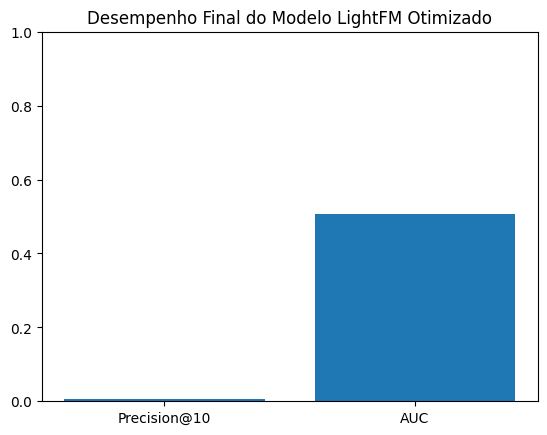

In [ ]:

# Treinar modelo final com melhores parâmetros
!pip install matplotlib
import matplotlib.pyplot as plt

model = LightFM(
    no_components=int(best['components']),
    learning_rate=best['learning_rate'],
    loss=best['loss'],
    random_state=42
)
model.fit(train_interactions, user_features=user_features, item_features=item_features,
          epochs=int(best['epochs']), num_threads=2, verbose=True)

prec, auc = evaluate_model(model, train_interactions, test_interactions, user_features, item_features)
print(f"\nDesempenho final → Precision@10: {prec:.4f}, AUC: {auc:.4f}")

plt.bar(['Precision@10', 'AUC'], [prec, auc])
plt.title('Desempenho Final do Modelo LightFM Otimizado')
plt.ylim(0, 1)
plt.show()





In [ ]:

#  SALVAR MODELO E FEATURES (implantação)
import pickle


with open("lightfm_bundle.pkl", "wb") as f:
    pickle.dump({
        "model": model,
        "user_features": user_features,
        "item_features": item_features,
        "dataset": dataset
    }, f)

print("✅ Modelo completo salvo em 'lightfm_bundle.pkl'.")

✅ Modelo completo salvo em 'lightfm_bundle.pkl'.


In [ ]:

#  CARREGAR MODELO SALVO

with open("lightfm_bundle.pkl", "rb") as f:
    bundle = pickle.load(f)

model = bundle["model"]
user_features = bundle["user_features"]
item_features = bundle["item_features"]
dataset = bundle["dataset"]

print("✅ Modelo e features carregados com sucesso!")

✅ Modelo e features carregados com sucesso!


In [ ]:
# FAZER RECOMENDAÇÕES PARA UM USUÁRIO ESPECÍFICO

import numpy as np
import pandas as pd

def recomendar_usuario(author_id, df, model, dataset, user_features, item_features,
                       top_n=10, batch_size=1000, top_popular_backup=True):
    """
    Gera recomendações personalizadas (ou populares, se o usuário for novo).

    Parâmetros:
      author_id (str): ID do usuário
      df (pd.DataFrame): DataFrame original (com colunas product_id, brand_name, product_name)
      model (LightFM): Modelo treinado
      dataset (Dataset): Dataset do LightFM (para mapeamentos)
      user_features, item_features: matrizes de features
      top_n (int): número de recomendações
      batch_size (int): tamanho dos lotes de predição
      top_popular_backup (bool): se True, usa produtos mais populares como fallback

    Retorna:
      Lista de tuplas (product_id, marca, nome, score)
    """
    user_id_map, _, item_id_map, _ = dataset.mapping()
    inv_item_map = {v: k for k, v in item_id_map.items()}
    n_items = len(item_id_map)

    # 🔹 CASO 1: Usuário novo (não visto no treino)
    if author_id not in user_id_map:
        print(f"⚠️ Usuário {author_id} não encontrado — exibindo recomendações gerais.")

        # Opção 1: Recomendação baseada em popularidade
        if top_popular_backup:
            populares = (
                df[df['is_recommended_numeric'] == 1]
                .groupby(['product_id', 'brand_name', 'product_name'])
                .size()
                .reset_index(name='n_recommend')
                .sort_values('n_recommend', ascending=False)
                .head(top_n)
            )
            recs = []
            for _, row in populares.iterrows():
                recs.append((row['product_id'], row['brand_name'], row['product_name'], row['n_recommend']))
            return recs

        # Opção 2: fallback baseado em média de scores (se preferir manter o modelo)
        user_idxs = np.arange(min(50, len(user_id_map)), dtype=np.int32)
        avg_scores = np.zeros(n_items, dtype=np.float32)

        for u in user_idxs:
            user_scores = model.predict(
                np.full(n_items, u, dtype=np.int32),
                np.arange(n_items, dtype=np.int32),
                user_features=user_features,
                item_features=item_features
            )
            avg_scores += user_scores
        avg_scores /= len(user_idxs)
        top_idx = np.argsort(-avg_scores)[:top_n]
        scores = avg_scores

    # 🔹 CASO 2: Usuário já existente no modelo
    else:
        user_idx = user_id_map[author_id]
        scores = np.empty(n_items, dtype=np.float32)

        for start in range(0, n_items, batch_size):
            end = min(start + batch_size, n_items)
            items_batch = np.arange(start, end, dtype=np.int32)
            users_batch = np.full_like(items_batch, user_idx, dtype=np.int32)
            scores[start:end] = model.predict(
                users_batch, items_batch,
                user_features=user_features,
                item_features=item_features
            )

        top_idx = np.argsort(-scores)[:top_n]

    # 🔹 Montar lista de recomendações
    recs = []
    for idx in top_idx:
        pid = inv_item_map[int(idx)]
        produto = df[df['product_id'] == pid]

        if not produto.empty:
            nome = produto['product_name'].iloc[0]
            marca = produto['brand_name'].iloc[0]
        else:
            nome = "Produto desconhecido"
            marca = "Marca desconhecida"

        recs.append((pid, marca, nome, float(scores[idx])))

    return recs


In [ ]:

#Recomendação

# Exemplo 1 — Usuário existente no modelo
usuario_existente = df['author_id'].iloc[0]
recs_existente = recomendar_usuario(usuario_existente, df, model, dataset, user_features, item_features, top_n=10)

print(f"\n🎯 Recomendações personalizadas para o usuário {usuario_existente}:")
for i, (pid, marca, nome, score) in enumerate(recs_existente, start=1):
    print(f"{i}. {marca} - {nome} (Score: {score:.4f})")


# Exemplo 2 — Usuário novo (não visto no treino)
usuario_novo = "22227672606"
recs_novo = recomendar_usuario(usuario_novo, df, model, dataset, user_features, item_features, top_n=10)

print(f"\n🆕 Recomendações gerais para o novo usuário {usuario_novo}:")
for i, (pid, marca, nome, score) in enumerate(recs_novo, start=1):
    print(f"{i}. {marca} - {nome} (Score: {score:.4f})")


⚠️ Usuário 22227672606 não encontrado — exibindo recomendações gerais.

🎯 Recomendações personalizadas para o usuário 22227672606:
1. LANEIGE - Lip Sleeping Mask Intense Hydration with Vitamin C (Score: 3679.0000)
2. Farmacy - Green Clean Makeup Meltaway Cleansing Balm Limited Edition Jumbo (Score: 2599.0000)
3. Farmacy - Green Clean Makeup Removing Cleansing Balm (Score: 2599.0000)
4. Dermalogica - Mini Daily Microfoliant Exfoliator (Score: 2598.0000)
5. Dermalogica - Daily Microfoliant Exfoliator (Score: 2598.0000)
6. Youth To The People - Superfood Antioxidant Cleanser (Score: 2223.0000)
7. Youth To The People - Mini Superfood Antioxidant Cleanser (Score: 2219.0000)
8. Estée Lauder - Estee Lauder Advanced Night Repair Synchronized Multi-Recovery Complex Serum (Score: 1910.0000)
9. Estée Lauder - Advanced Night Repair Synchronized Multi-Recovery Complex Duo (Score: 1910.0000)
10. Estée Lauder - Mini Advanced Night Repair Synchronized Multi-Recovery Complex (Score: 1910.0000)
⚠️ Usuár